# Waze

## О компании
Waze — бесплатное приложение для мобильных устройств, позволяющее отслеживать дорожную обстановку в реальном времени, создавать оптимальные маршруты и обмениваться информацией о дорожных условиях с другими пользователями. Карты создаются сообществом.

## Цель проекта
Разработать модель машинного обучения для прогнозирования оттока пользователей. Отток измеряет количество пользователей, которые удалили приложение Waze или прекратили его использование.

## Информация о данных
В этом наборе данных, имеется 14 999 строк и 13 столбцов

| Имя столбца             | Описание                                                                                                                                |
|-------------------------|-----------------------------------------------------------------------------------------------------------------------------------------|
| ID                      | Последовательный индекс с номерами                                                                                                      |
| label                   | Колонка с бинарной целевой переменной содержит информацию о том, остался ли пользователь (retained) или ушел (churned) в течение месяца |
| sessions                | Количество случаев, когда пользователь открывал приложение в течение месяца                                                             |
| drives                  | Случаи проезда не менее 1 км в течение месяца                                                                                           |
| device                  | Тип устройства, с которого пользователь начинает сеанс                                                                                  |
| total_sessions          | Общеее количество сеансов с момента регистрации пользователя                                                           |
| n_days_after_onboarding | Количество дней с момента регистрации пользователя в приложении                                                                         |
| total_navigations_fav1  | Общее количество поездок с момента регистрации пользователя в любимое место 1                                                           |
| total_navigations_fav2  | Общее количество поездок с момента регистрации пользователя в любимое место 2                                                           |
| driven_km_drives        | Общий километраж, пройденный за месяц                                                                                                   |
| duration_minutes_drives | Общая продолжительность поездки в минутах в течение месяца                                                                              |
| activity_days           | Количество дней, когда пользователь открывает приложение в течение месяца                                                               |
| driving_days            | Количество дней, в течение которых пользователь проезжает (не менее 1 км) в течение месяца.                                             |

## Этап 1. Импорт

* Импорт библиотек
* Загрузка набора данных

### Импорт библиотек

In [1]:
# Для работы с данными
import numpy as np
import pandas as pd

# Для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Для отображения всех столбцов в фреймах данных
pd.set_option('display.max_columns', None)

# Для моделирования данных
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Для получения метрик и полезных функций
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

### Загрузка набора данных

In [2]:
# Загрузка данных из файла с именем 'waze_dataset.csv'
df = pd.read_csv('/content/waze_dataset.csv')

# Вывод нескольких строк набора данных
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


## Этап 2. Исследование данных

- Понимание переменных
- Очистка набора данных (недостающие данные, избыточные данные, отклонения)
- Визуализация

### Вывод основной информации о данных

In [3]:
# Вывод информации о структуре данных и типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [4]:
# Вывод основной статистической информации о числовых данных
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


- Ни одна из переменных в первых 10 наблюдениях не содержит отсутствующих значений. Следует отметить, что это не подразумевает, что весь набор данных не содержит пропущенных значений.
- В столбце `label` имеется 700 пропущенных значений.

### Сравнение двух наборов данных

Сравним сводную статистику 700 строк, в которых отсутствуют метки, со сводной статистикой строк, в которых не пропущено ни одного значения.

In [5]:
# Создание нового набора данных, где 'label' имеет пустые значения
null_df = df[df['label'].isnull()]

# Вывод основной статистической информации о числовых данных
null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,7405.584286,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,4306.900234,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,77.000000,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,3744.500000,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,7443.000000,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,11007.000000,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,14993.000000,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [6]:
# Создание нового набора данных, где 'label' НЕ имеет пустые значения
not_null_df = df[~df['label'].isnull()]

# Вывод основной статистической информации о числовых данных
not_null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


Сравнение общих статистических показателей между двумя наборами данных, не выявило существенных различий. Средние значения и стандартные отклонения в этих двух группах оказались практически идентичными.

### Распределение устройств

Теперь проверим столбец `device` на распределение платформ пользователей.

In [7]:
# Проверка распределения устройств в столбце device
null_df['device'].value_counts()

iPhone     447
Android    253
Name: device, dtype: int64

Из 700 строк с нулевыми значениями 447 были пользователями iPhone и 253 — пользователями Android.


Теперь для строк с нулевыми значениями вычислим процентное соотношение для каждого устройства — Android и iPhone.

In [8]:
# Рассчет процента пропущенных значений для iPhone и Android
null_df['device'].value_counts(normalize=True)

iPhone     0.638571
Android    0.361429
Name: device, dtype: float64

In [9]:
# Рассчет процента пользователей iPhone и пользователей Android в полном наборе данных
df['device'].value_counts(normalize=True)

iPhone     0.644843
Android    0.355157
Name: device, dtype: float64

Процент пропущенных значений для каждого устройства согласуется с их представлением в общих данных. Нет ничего, что указывало бы на нерандомную причину отсутствующих данных.

### Анализ двух групп пользователей

Изучим количество и процент пользователей, которые ушли, по сравнению с теми, кто остался.

In [10]:
# Рассчет количества пользователей, покинувших приложение (churned), и количество оставшихся (retained)
print(df['label'].value_counts())
print()
print(df['label'].value_counts(normalize=True))

retained    11763
churned      2536
Name: label, dtype: int64

retained    0.822645
churned     0.177355
Name: label, dtype: float64


Этот набор данных содержит 82% оставшихся пользователей и 18% ушедших пользователей.

Затем сравним медианы каждой переменной для ушедших и оставшихся пользователей. Причина расчета медианы, а не среднего значения, заключается в том, что мы хотим, чтобы выбросы не чрезмерно влияли на изображение типичного пользователя. Например, максимальное значение в столбце `Drive_km_drives` составляет 21 183 км. Это больше половины окружности Земли!

In [11]:
# Рассчет медианного значения всех столбцов для ушедших и оставшихся пользователей.
df.groupby('label').median(numeric_only=True)

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
label,,,,,,,,,,,
churned,7477.5,59.0,50.0,164.339042,1321.0,84.5,11.0,3652.655666,1607.183785,8.0,6.0
retained,7509.0,56.0,47.0,157.586756,1843.0,68.0,9.0,3464.684614,1458.046141,17.0,14.0


Это дает интересное представление о двух группах: ушедших и оставшихся пользователях
- Ушедшие пользователи за последний месяц совершили в среднем примерно на 3 больше поездок, чем удержанные пользователи, но оставшиеся пользователи использовали приложение более чем в два раза больше дней, чем ушедшие пользователи за тот же период времени.
- Средний ушедший пользователь проехал примерно на 200 километров больше и на 2,5 часа больше за последний месяц, чем средний оставшийся пользователь.

Похоже, что ушедшие пользователи совершали больше поездок за меньшее количество дней, а их поездки были дальше и длительнее. Возможно, это наводит на мысль о профиле пользователя.

Рассчитаем медианный километраж за последний месяц для оставшихся и ушедших пользователей.

In [12]:
# Группировка данных по `label` и вычисление медианы
medians_by_label = df.groupby('label').median(numeric_only=True)
print('Медианное количество километров за поездку:')
# Разделим медианное расстояние на медианное количество поездок
medians_by_label['driven_km_drives'] / medians_by_label['drives']

Медианное количество километров за поездку:


label
churned     73.053113
retained    73.716694
dtype: float64

Медианный пользователь из обеих групп проезжал ~73 км/день.

In [13]:
# Разделим медианное расстояние на медианное количество дней езды
print('Медианное количество километров в день вождения:')
medians_by_label['driven_km_drives'] / medians_by_label['driving_days']

Медианное количество километров в день вождения:


label
churned     608.775944
retained    247.477472
dtype: float64

Теперь рассчитаем медианное количество поездок за день для каждой группы.

In [14]:
# Разделим медианное количество поездок на медианное количество дней вождения
print('Медианное количество поездок в день вождения:')
medians_by_label['drives'] / medians_by_label['driving_days']

Медианное количество поездок в день вождения:


label
churned     8.333333
retained    3.357143
dtype: float64

Пользователи, которые покинули сервис, в среднем проезжали 608 километров каждый день в прошлом месяце, что почти в 250% больше, чем расстояние, преодоленное пользователями, которые остались. Пользователи, которые ушли, в среднем также имели несоразмерно большее количество поездок в день по сравнению с пользователями, которые остались.

Из этих данных ясно, что независимо от того, ушел ли пользователь или нет, пользователи, представленные в этих данных, серьезно увлечены вождением! Можно предположить, что эти данные не представляют типичных водителей в общем. Возможно, данные, и особенно выборка ушедших пользователей, содержат высокий процент дальнобойщиков.

Учитывая, насколько много эти пользователи ездят, было бы разумно рекомендовать Waze собирать больше данных об этих "супер-водителях". Возможно, причина их интенсивного вождения также объясняет, почему приложение Waze не соответствует их конкретным потребностям, которые могут отличаться от потребностей более типичного водителя.


### Анализ дисбаланса ушедших пользователей по типам устройств

И наконец, изучим, существует ли дисбаланс в количестве ушедших пользователей по типам устройств.

Начнем с получения общего количества устройств каждого типа для каждой группы, оттока и удержания.

In [15]:
# Подсчет для каждой группы количество пользователей Android и пользователей iPhone
df.groupby(['label', 'device']).size()

label     device 
churned   Android     891
          iPhone     1645
retained  Android    4183
          iPhone     7580
dtype: int64

Теперь внутри каждой группы, оттока и удержания, подсчитаем, какой процент приходится на Android, а какой - на iPhone.

In [16]:
# Рассчет для каждой группы процентное соотношение пользователей Android и iPhone
df.groupby('label')['device'].value_counts(normalize=True)

label     device 
churned   iPhone     0.648659
          Android    0.351341
retained  iPhone     0.644393
          Android    0.355607
Name: device, dtype: float64

Соотношение пользователей iPhone и Android в группе "оттока" и в группе "удержания" соответствует соотношению в общем наборе данных.

- Датасет содержал 700 пропущенных значений в столбце `label`. Очевидного шаблона в отсутствующих значениях не было.
- Пользователи Android составляли примерно 36% выборки, в то время как пользователи iPhone составляли около 64%.
- Уровень оттока для пользователей iPhone и Android различался менее чем на один процентный пункт. Ничего не указывает на корреляцию оттока пользователей с устройством.
- Пользователи, которые ушли, проезжали больше и дольше в меньшее количество дней, чем оставшиеся пользователи. Ушедшие пользователи также использовали приложение примерно вдвое меньше раз по сравнению с удержанными пользователями за тот же период.

### Визуализация данных

Начнем с изучения разброса и распределения важных переменных с помощью графиков и гистограмм.

`sessions`

Количество случаев открытия приложения пользователем в течение месяца

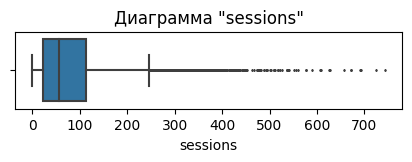

In [17]:
# Построение диаграммы
plt.figure(figsize=(5,1))
sns.boxplot(x=df['sessions'], fliersize=1)
plt.title('Диаграмма "sessions"');

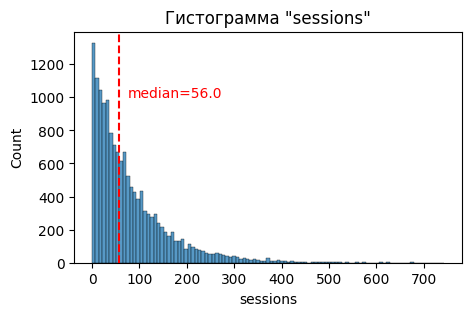

In [18]:
# Построение гистограммы
plt.figure(figsize=(5,3))
sns.histplot(x=df['sessions'])
median = df['sessions'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(75,1000, 'median=56.0', color='red')
plt.title('Гистограмма "sessions"');

Переменная `sessions` имеет правостороннее распределение, причем половина наблюдений имеет 56 и менее сессий. Однако некоторые пользователи имеют более 700 сессий.

`drives`

Пробег не менее 1 км в течение месяца

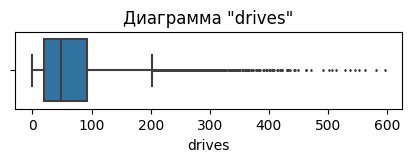

In [19]:
# Построение диаграммы
plt.figure(figsize=(5,1))
sns.boxplot(x=df['drives'], fliersize=1)
plt.title('Диаграмма "drives"');

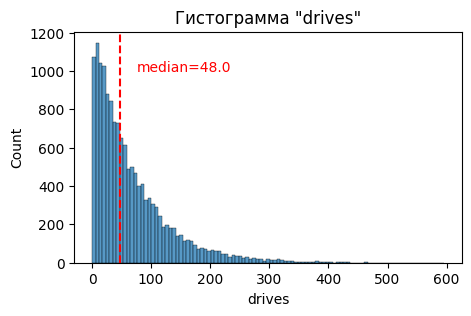

In [20]:
# Построение гистограммы
plt.figure(figsize=(5,3))
sns.histplot(x=df['drives'])
median = df['drives'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(75,1000, 'median=48.0', color='red')
plt.title('Гистограмма "drives"');

Столбец `drives` имеет распределение, аналогичное переменной `sessions`. Тоже имеет правостороннее распределение с медианой 48. Однако у некоторых водителей за последний месяц было более 400 поездок.

`total_sessions`

Общеее количество сеансов с момента регистрации пользователя.

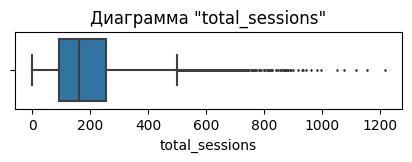

In [21]:
# Построение диаграммы
plt.figure(figsize=(5,1))
sns.boxplot(x=df['total_sessions'], fliersize=1)
plt.title('Диаграмма "total_sessions"');

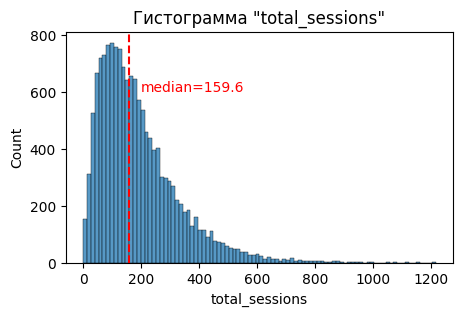

In [22]:
# Построение гистограммы
plt.figure(figsize=(5,3))
sns.histplot(x=df['total_sessions'])
median = df['total_sessions'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(200,600, 'median=159.6', color='red')
plt.title('Гистограмма "total_sessions"');

Показатель `total_sessions` имеет правостороннее распределение. Медиана общего количества сессий составляет 159,6. Эта информация представляет интерес, поскольку, если медианное количество сеансов за последний месяц составило 56, а медианное общее количество сеансов — около 160, то, вероятно, большая часть общего числа сеансов пользователя приходится на последний месяц.

`n_days_after_onboarding`

Количество дней, прошедших с момента регистрации пользователя в приложении.

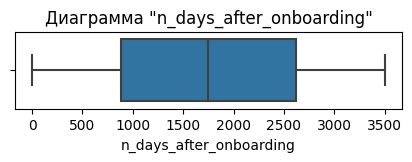

In [23]:
# Построение диаграммы
plt.figure(figsize=(5,1))
sns.boxplot(x=df['n_days_after_onboarding'], fliersize=1)
plt.title('Диаграмма "n_days_after_onboarding"');

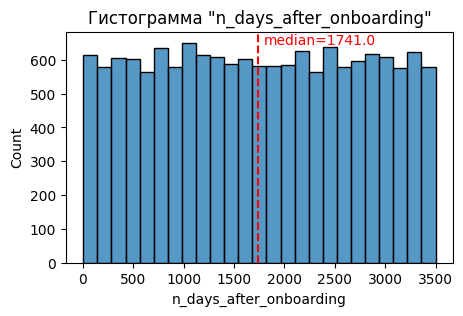

In [24]:
# Построение гистограммы
plt.figure(figsize=(5,3))
sns.histplot(x=df['n_days_after_onboarding'])
median = df['n_days_after_onboarding'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(1800,645, 'median=1741.0', color='red')
plt.title('Гистограмма "n_days_after_onboarding"');

Общее оличество дней с момента регистрации в приложении имеет равномерное распределение со значениями от почти нулевых до \~3 500 дней (\~9,5 лет).

`driven_km_drives`

Общее количество километров, пройденных за месяц.

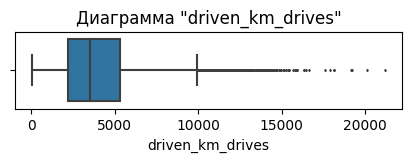

In [25]:
# Построение диаграммы
plt.figure(figsize=(5,1))
sns.boxplot(x=df['driven_km_drives'], fliersize=1)
plt.title('Диаграмма "driven_km_drives"');

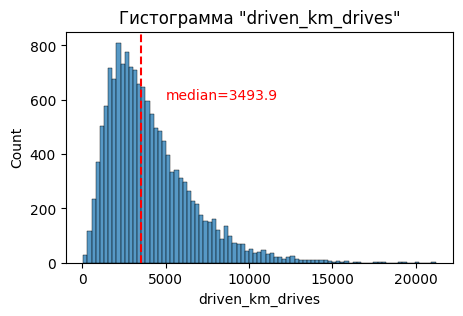

In [26]:
# Построение гистограммы
plt.figure(figsize=(5,3))
sns.histplot(x=df['driven_km_drives'])
median = df['driven_km_drives'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(5000,600, 'median=3493.9', color='red')
plt.title('Гистограмма "driven_km_drives"');

Количество поездок за последний месяц на одного пользователя имеет правостороннее распределение, причем половина пользователей проехала менее 3494 км. В ходе анализа стало ясно, что пользователи в этом наборе данных много путешествуют. Например, самое большое расстояние, пройденное за месяц, составило более половины окружности Земли.

`duration_minutes_drives`

Общая продолжительность поездок в минутах за месяц.

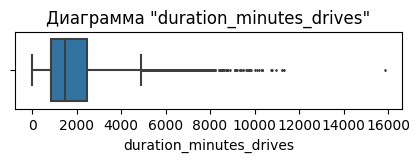

In [27]:
# Построение диаграммы
plt.figure(figsize=(5,1))
sns.boxplot(x=df['duration_minutes_drives'], fliersize=1)
plt.title('Диаграмма "duration_minutes_drives"');

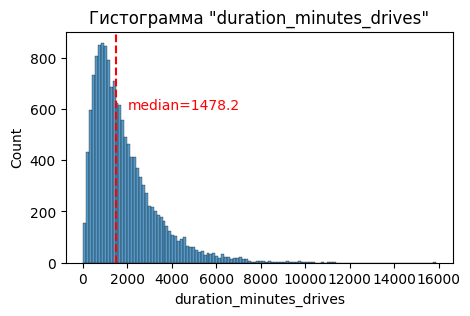

In [28]:
# Построение гистограммы
plt.figure(figsize=(5,3))
sns.histplot(x=df['duration_minutes_drives'])
median = df['duration_minutes_drives'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(2000,600, 'median=1478.2', color='red')
plt.title('Гистограмма "duration_minutes_drives"');

Переменная `duration_minutes_drives` имеет сильно перекошенный правый хвост. Половина пользователей проехала менее \~1 478 минут (\~25 часов), но некоторые пользователи за месяц накатали более 250 часов.

`activity_days`

Количество дней, когда пользователь открывает приложение в течение месяца.

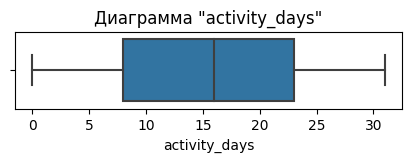

In [29]:
# Построение диаграммы
plt.figure(figsize=(5,1))
sns.boxplot(x=df['activity_days'], fliersize=1)
plt.title('Диаграмма "activity_days"');

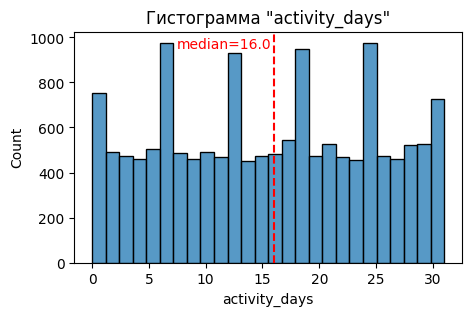

In [30]:
# Построение гистограммы
plt.figure(figsize=(5,3))
sns.histplot(x=df['activity_days'])
median = df['activity_days'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(7.5,950, 'median=16.0', color='red')
plt.title('Гистограмма "activity_days"');

За последний месяц пользователи открывали приложение в среднем 16 раз. Графическая диаграмма показывает центрированное распределение. Гистограмма показывает почти равномерное распределение: \~500 человек открывали приложение в каждый из дней. Однако есть \~770 человек, которые не открывали приложение вообще, и \~770 человек, которые открывали приложение каждый день в течение месяца.

Это распределение примечательно тем, что оно не совпадает с распределением `sessions`, которое, как можно было бы предположить, тесно коррелирует с `activity_days`.

`driving_days`

Количество дней, когда пользователь ездил за рулем (не менее 1 км) в течение месяца.

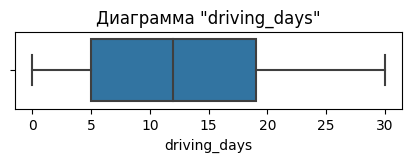

In [31]:
# Построение диаграммы
plt.figure(figsize=(5,1))
sns.boxplot(x=df['driving_days'], fliersize=1)
plt.title('Диаграмма "driving_days"');

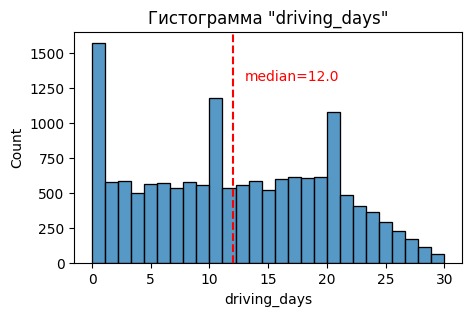

In [32]:
# Построение гистограммы
plt.figure(figsize=(5,3))
sns.histplot(x=df['driving_days'])
median = df['driving_days'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(13,1300, 'median=12.0', color='red')
plt.title('Гистограмма "driving_days"');

Количество дней, в которые пользователи ездили за рулем в каждом месяце, практически одинаково и в значительной степени коррелирует с количеством дней, когда они открывали приложение в том же месяце, за исключением того, что распределение driving_days смещено вправо.

Однако почти втрое больше пользователей (~1500 против ~550) вообще не водили машину в течение месяца. Это может показаться нелогичным при анализе в сочетании с информацией из переменной activity_days. В этой переменной ~500 пользователей открывали приложение в каждый из большинства дней, но есть всего ~770 пользователей, которые не открывали приложение в течение месяца вообще, и ~770 пользователей, которые открывали приложение каждый день. Эти данные стоит отметить для дальнейшего исследования

`driving_days` vs. `activity_days`

Поскольку и `driving_days`, и `activity_days` представляют собой количество дней в течение месяца, а также тесно связаны между собой, их можно построить на одной гистограмме. Это поможет лучше понять, как они связаны друг с другом.

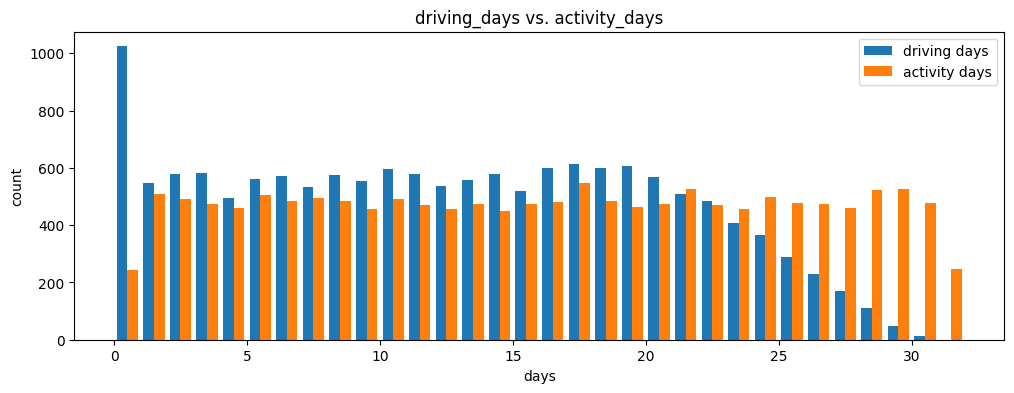

In [33]:
# Построение гистограммы
plt.figure(figsize=(12,4))
label=['driving days', 'activity days']
plt.hist([df['driving_days'], df['activity_days']],
         bins=range(0,33),
         label=label)
plt.xlabel('days')
plt.ylabel('count')
plt.legend()
plt.title('driving_days vs. activity_days');

Как уже отмечалось, это может показаться нелогичным. В конце концов, почему количество людей, которые вообще не пользовались приложением в течение месяца, меньше, чем количество тех, кто вообще не водил машину в течение месяца, больше?

С другой стороны, это может быть просто иллюстрацией того факта, что, хотя эти переменные взаимосвязаны, они не идентичны. Возможно, люди чаще открывают приложение, чем используют его для вождения— возможно, для проверки времени поездки или информации о маршруте, для обновления настроек или даже просто по ошибке.

Подтвердим максимальное количество дней для каждой переменной&mdash;`driving_days` и `activity_days`.

In [34]:
print(df['driving_days'].max())
print(df['activity_days'].max())

30
31


Маловероятно, что какой-то пользователь ездил за рулем все 31 день месяца, учитывая, что в наборе данных представлено 15 000 человек. Еще один способ проверить достоверность этих переменных — построить простую диаграмму рассеяния, где ось x представляет одну переменную, а ось y — другую.

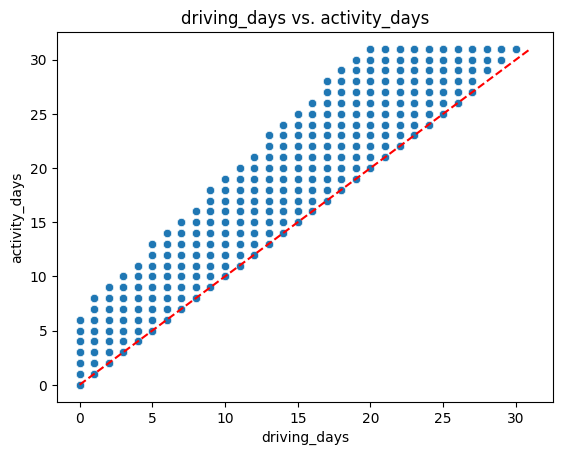

In [35]:
# Диаграмма рассеяния
sns.scatterplot(data=df, x='driving_days', y='activity_days')
plt.title('driving_days vs. activity_days')
plt.plot([0,31], [0,31], color='red', linestyle='--');

Существует теоретический предел. Если вы используете приложение для управления автомобилем, то по определению это также должно считаться днем использования. Другими словами, количество дней использования приложения не может превышать количество дней активности. Ни один из примеров в этих данных не нарушает это правило, что очень хорошо.

**Удержание по устройствам**

Построим гистограмму, состоящую из четырех столбиков&mdash; по одному для каждой комбинации "устройство-метка&mdash;", чтобы показать, сколько пользователей iPhone остались/отказались от использования и сколько пользователей Android остались/отказались от использования.

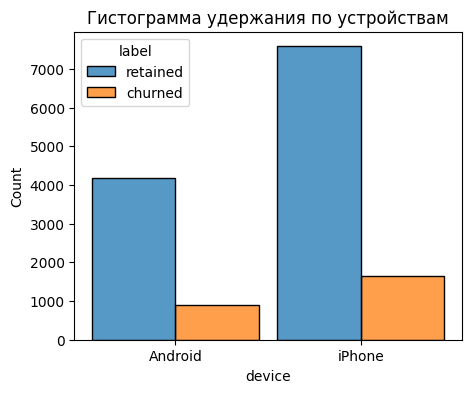

In [36]:
# Построение гистограммы
plt.figure(figsize=(5,4))
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.title('Гистограмма удержания по устройствам');

**Удержание по пройденным километрам за день**

Мы обнаружили, что медианное расстояние, пройденное за день за рулем в прошлом месяце для пользователей, которые отказались от услуг, составило 608,78 км, в сравнении с 247,48 км для тех, кто не отказался от услуг. Давайте проведем более детальный анализ этого явления.

In [37]:
# Создание колонки `km_per_driving_day`
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Вывод основной статистической информации о числовых данных о новой колонке
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Это результат того, что в столбце `driving_days` есть значения, равные нулю. Pandas подставляет значение бесконечности в соответствующие строки нового столбца, поскольку деление на ноль не определено.


In [38]:
# Преобразование этих значений из бесконечности в ноль. Для обозначения значения бесконечности можно использовать `np.inf`.
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Вывод основной статистической информации о числовых данных о новой колонке
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

Максимальное значение составляет 15 420 км _за один день езды_. Это физически невозможно. Если ехать со скоростью 100 км/час в течение 12 часов, то это 1 200 км. Маловероятно, что многие люди в среднем проезжают за день больше этого значения, поэтому пока не учитываем строки, в которых расстояние в этом столбце больше 1 200 км.

Построим гистограмму нового столбца `km_per_driving_day`, отбросив пользователей со значениями, превышающими 1 200 км. Каждый столбец должен иметь одинаковую длину и два цвета: один цвет представляет процент пользователей в этом столбце, которые ушли, а другой - процент, который остался.

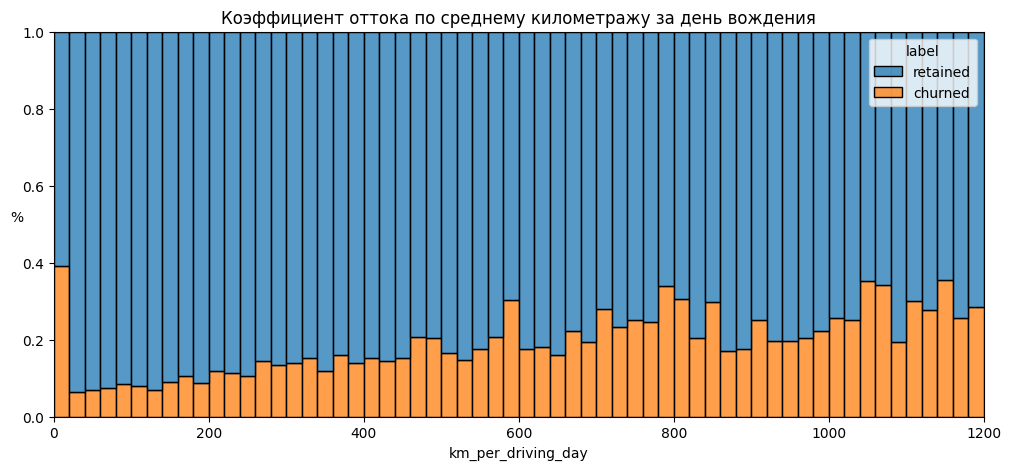

In [39]:
# Построение гистограммы
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='km_per_driving_day',
             bins=range(0,1201,20),
             hue='label',
             multiple='fill')
plt.ylabel('%', rotation=0)
plt.title('Коэффициент оттока по среднему километражу за день вождения');

Коэффициент оттока имеет тенденцию к увеличению по мере роста среднесуточного пробега, что подтверждает результаты, полученные ранее. Стоит подробнее изучить причины, по которым пользователи, совершающие поездки на дальние расстояния, прекращают пользоваться приложением.

**Коэффициент оттока за количество дней вождения**

Создадим еще одну гистограмму, аналогичную предыдущей, только на этот раз она должна представлять коэффициент оттока для каждого количества дней вождения.

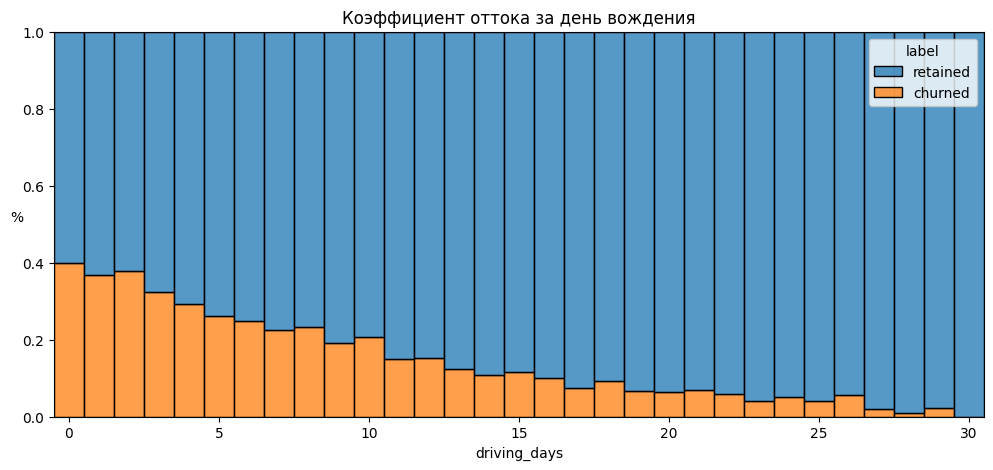

In [40]:
# Построение гистограммы
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='driving_days',
             bins=range(1,32),
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Коэффициент оттока за день вождения');

Наиболее высок процент оттока среди тех, кто не пользовался Waze в течение последнего месяца. Чем больше раз они пользовались приложением, тем меньше вероятность оттока. В то время как 40% пользователей, которые вообще не пользовались приложением в прошлом месяце, отписались, никто из тех, кто пользовался приложением 30 дней, не отписался.
Это неудивительно. Если бы люди, которые часто пользовались приложением, уходили, это, скорее всего, свидетельствовало бы о неудовлетворенности. Если же люди не пользуются приложением, то это может быть результатом неудовлетворенности в прошлом, либо свидетельствовать о снижении потребности в навигационном приложении. Возможно, они переехали в город с хорошим общественным транспортом, и им больше не нужно водить машину.

### Инсайты

- **Чем больше раз пользователи использовали приложение, тем меньше вероятность того, что они уйдут.** В то время как 40% пользователей, которые вообще не использовали приложение в прошлом месяце, ушли, никто из тех, кто использовал приложение в течение 30 дней, не ушел.
- **Расстояние, пройденное за день вождения, имело положительную корреляцию с оттоком пользователей.** Чем дальше пользователь проезжал за каждый день вождения, тем больше вероятность того, что он уйдет.
- **Количество дней вождения отрицательно коррелировало с оттоком.** Пользователи, которые в прошлом месяце ездили больше дней, имели меньшую вероятность уйти.
- **Пользователи с момента регистрации в приложении, от совершенно новых до примерно 10 лет, были относительно равномерно представлены в данных.**
- **Почти все переменные были либо сильно смещены вправо, либо распределены равномерно.**
 - Для правостороннего распределения это означает, что большинство пользователей имели значения этой переменной в нижней части диапазона.
 - Для равномерного распределения это означает, что пользователи, как правило, с одинаковой вероятностью будут иметь значения этой переменной в любом месте диапазона.
- Некоторые переменные имели крайне маловероятные или, возможно, даже невозможные внешние значения , такие как `Drive_km_drives`, `Activity_days` и `Driving_days`.

## Этап 3. Построение модели

#### Подготовка данных

Мы уже подготовили большую часть данных и провели исследовательский анализ данных. Также мы выяснили, что некоторые характеристики имеют более сильную корреляцию с оттоком, чем другие. Кроме того, мы создали несколько характеристик, которые могут оказаться полезными.

Для начала создадим копию `df`, чтобы сохранить исходный набор данных. Назовем копию `df0`.

In [41]:
# Копирование набора данных
df0 = df.copy()

**`percent_sessions_in_last_month`**

Создадим новый столбец `percent_sessions_in_last_month`, который представляет собой процент от общего числа сеансов каждого пользователя, зарегистрированных в последний месяц его использования.

In [42]:
# Создание нового столбца `percent_sessions_in_last_month`
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# Вывод основной статистической информации о числовых данных
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

**`professional_driver`**

Создадим новый бинарный признак `professional_driver`, который будет равен 1 для пользователей, совершивших 60 и более поездок и управлявших автомобилем более 15 дней за последний месяц.

Задача состоит в том, чтобы создать новый признак, отделяющий профессиональных водителей от других водителей.

Для создания такого столбца используется функция `np.where()`. Эта функция принимает в качестве аргументов:
1. Условие
2. Что возвращать, если условие истинно
3. Что возвращать, если условие ложно

In [43]:
# Создание нового столбца `professional_driver`
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

**`total_sessions_per_day`**

Теперь создадим новый столбец, представляющий среднее количество сеансов в день с момента начала работы.

In [44]:
# Создание нового столбца `total_sessions_per_day`
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']
# Вывод основной статистической информации о числовых данных
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

**`km_per_hour`**

Создадим столбец, представляющий среднее количество километров в час, пройденных за последний месяц.

In [45]:
# Создание нового столбца `km_per_hour`
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
# Вывод основной статистической информации о числовых данных
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

Эти числа вызывают определенные сомнения, и для более глубокого понимания причин таких невероятных скоростей было бы полезно получить объяснения относительно методологии сбора данных.

К примеру:

- Средняя скорость в км/ч за последний месяц. В данном случае, среднее значение составляет 190,39 км/ч, что представляется весьма высоким.
- Стандартное отклонение довольно высоко (334,67 км/ч), что может свидетельствовать о значительной вариабельности в данных.
- Максимальное значение - 23642,92 км/ч. Это аномально высокая скорость и, вероятно, требует дополнительного изучения, поскольку она может быть вызвана ошибками в данных или выбросами.

**`km_per_drive`**

Создадим столбец, представляющий среднее количество километров, пройденных за последний месяц каждым пользователем.

In [46]:
# Создание нового столбца `km_per_drive`
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
# Вывод основной статистической информации о числовых данных
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

Эта колонка также имеет бесконечные значения. Преобразуем бесконечные значения к нулю.

In [47]:
# Преобразование бесконечных значений в нулевые
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# Вывод основной статистической информации о числовых данных
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

**`percent_of_sessions_to_favorite`**.

Наконец, создадим новый столбец, представляющий процент от общего числа сеансов, которые были использованы для поездки к одному из любимых мест пользователей. Затем выведем описательную статистику для нового столбца.

Это косвенное представление процента от общего числа поездок к любимому месту. Поскольку общее количество поездок с момента регистрации не содержится в этом наборе данных, в качестве разумного приближения следует использовать общее количество сеансов.

Люди, чьи поездки в не-любимые места составляют больший процент от общего числа поездок, могут быть менее склонны к оттоку, поскольку они совершают больше поездок в менее знакомые места.

In [48]:
# Создание нового столбца `percent_of_sessions_to_favorite`
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Вывод основной статистической информации о числовых данных
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

#### Удаление пропущенных значений
Из анализа известно, что нет никаких доказательств неслучайной причины отсутствия 700 значений в столбце `label`, и поскольку эти наблюдения составляют менее 5% данных, используем метод `dropna()` для удаления строк, в которых отсутствуют эти данные.

In [49]:
# Удалим строки с отсутствующими значениями
df = df.dropna(subset=['label'])

Во многих столбцах присутствуют выбросы данных. Однако модели, основанные на деревьях, не так чувствительны к выбросам, поэтому нет необходимости внесения каких-либо изменений.

### Кодирование переменных

**Двоичные признаки**

Для использования переменной `device` в качестве признака в модели, ее необходимо преобразовать в бинарный формат, поскольку эта переменная является категориальной. Важно отметить, что каждая уникальная категория переменной `device` будет преобразована в отдельный признак модели. Это может привести к проблемам, таким как несбалансированное соотношение признаков и наблюдений или затруднение в интерпретации результатов.

Поскольку в данном наборе данных у нас только одна категориальная переменная (`device`), нет необходимости использовать специальные функции для преобразования. Мы можем легко реализовать преобразование напрямую.

Создадим новый бинарный столбец `device2`, который будет кодировать устройства пользователей следующим образом:

- `Android` -> `0`
- `iPhone` -> `1`

In [50]:
# Создание нового бинарного столбца `device2`
df.loc[:, 'device2'] = np.where(df['device'] == 'Android', 0, 1)
df[['device', 'device2']].tail()

<ipython-input-50-d796250a28fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'device2'] = np.where(df['device'] == 'Android', 0, 1)


,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


**Кодирование целевой переменной**

Целевая переменная также является категориальной, поскольку пользователю присваивается метка "ушедший" или "оставшийся". Изменим тип данных столбца `label` на бинарный.

- Присвоим 0 всем пользователям с меткой "оставшийся".

- Присвоим 1 всем пользователям с меткой "ушедший".

Сохраним эту переменную как `label2`, чтобы не перезаписывать оригинальную переменную `label`.


In [51]:
# Создание нового бинарного столбца `label2`
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

<ipython-input-51-03696ca39d57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label2'] = np.where(df['label']=='churned', 1, 0)


,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### Отбор признаков

Модели на основе деревьев могут работать с мультиколлинеарностью, поэтому единственный признак, который можно отсечь, является ID, поскольку он не содержит никакой информации, относящейся к оттоку пользователей.
`device` не будет использоваться только потому, что оно является копией `device2`.

Удалим ID из набора данных `df`

In [52]:
# Удаление столбца `ID`
df = df.drop(['ID'], axis=1)

### Метрика оценки


Перед началом моделирования необходимо определиться с метрикой оценки. Она будет зависеть от баланса классов целевой переменной и сценария использования модели.
Сначала изучим баланс классов целевой переменной.

In [53]:
# Вывод баланс классов столбца 'label'
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

### Процесс выбора модели

Примерно 18% пользователей в этом наборе данных ушли. Это несбалансированный набор данных, но его можно моделировать без перебалансировки классов. Точность может не быть лучшим показателем производительности, потому что модель может иметь высокую точность на несбалансированном наборе данных и при этом все равно не справляться с предсказанием.

Итоговый набор данных для моделирования содержит 14 299 образцов. Это не совсем то, что можно считать достаточным для проведения надежного процесса отбора моделей, но все же выполнимо.

1. Разделить данные на наборы тренировка/валидация/тестирование (60/20/20).

При определении соотношения разбиения и необходимости использования валидационного набора для выбора модели-чемпиона следует учитывать как количество образцов в каждом разделе данных, так и количество примеров класса меньшинства в каждом из них. В данном случае при разделении 60/20/20 мы получим \~2 860 образцов в валидационном наборе и столько же в тестовом, из которых \~18%&mdash; или 515 образцов&mdash; будут представлять пользователей, которые ушли.

2. Подогнать модели и настроить гиперпараметры на обучающем множестве.
3. Провести окончательный отбор моделей на валидационном множестве.
4. Оценка эффективности модели-чемпиона на тестовом множестве.

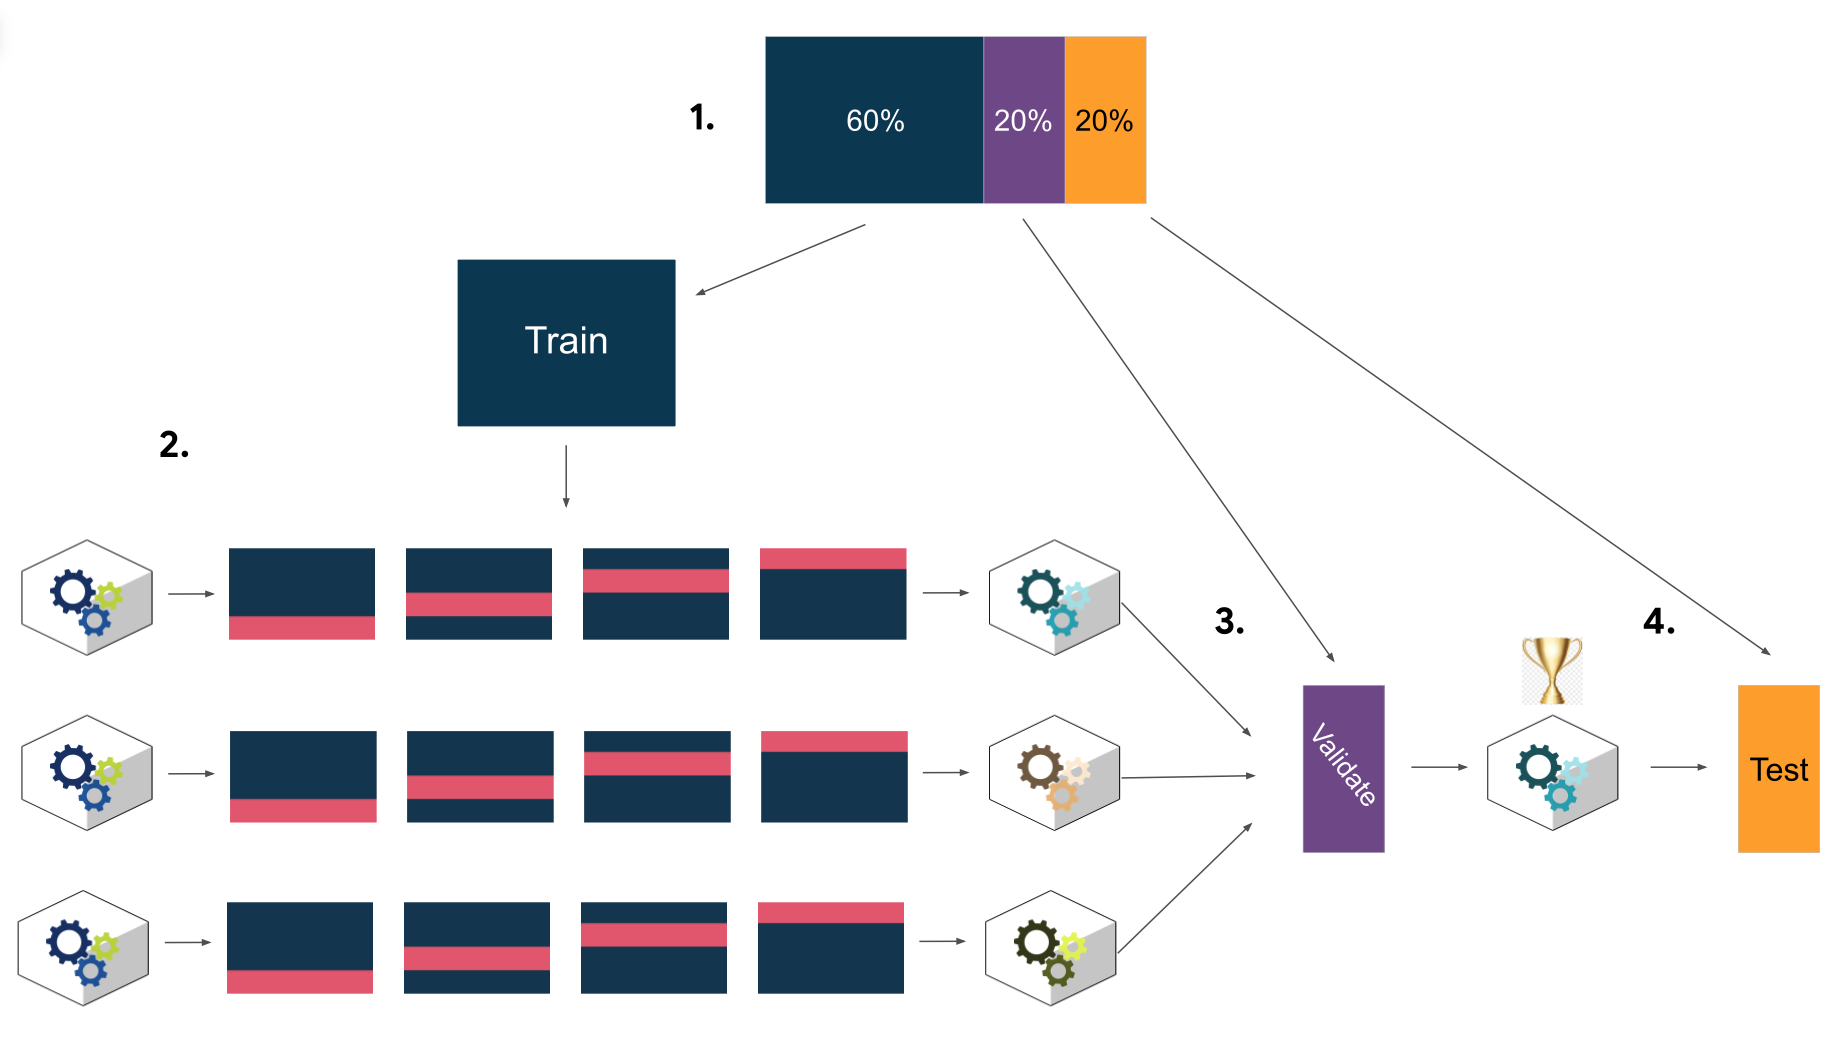


### Разделение данных

Проведем процесс разделения данных на наборы признаков и целевых переменных, а затем разделим данные на обучающий, проверочный и тестовый наборы с соотношениями 80/20 и 60/20/20 соответственно.

1. Определим переменную `X`, которая будет содержать признаки.
2. Определим переменную `Y` для целевой переменной (`label2`).
3. Разделим данные на обучающий и тестовый наборы в соотношении 80/20.
4. Затем разделим обучающий набор на обучающий и проверочный наборы в соотношении 75/25, чтобы получить итоговые пропорции 60/20/20 для обучения, валидации и тестирования.

In [54]:
# 1. Определение переменной X
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Определение переменной Y
y = df['label2']

# 3. Разделение данных на обучающий и тестовый наборы
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Разделение на обучающее и валидационные наборы
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

Проверим количество образцов в разбитых на разделы данных.

In [55]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


### Моделирование

**Случайный лес**

Начнем с использования `GridSearchCV` для настройки модели случайного леса

1. Создадим классификатор случайного леса `rf` и установим случайное состояние.

2. Создадим словарь `cv_params` с любыми из следующих гиперпараметров и их соответствующими значениями для настройки. Чем больше мы настраиваем, тем лучше наша модель будет соответствовать данным, но это займет больше времени.
 - `max_depth`
 - `max_features`
 - `max_samples`
 - `min_samples_leaf`
 - `min_samples_split`
 - `n_estimators`

3. Определим набор `scoring` метрик для оценки GridSearch (precision, recall, F1 score, и accuracy).

4. Создадим объект `GridSearchCV` с именем `rf_cv`. И передадим ему следующие аргументы:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: определим количество блоков перекрестной проверки, которое вы хотите
   (`cv=_`)
 - refit: укажем, какую метрику оценки мы хотим использовать для выбора модели
   (`refit=_`)

In [56]:
# 1. Установка классификатора случайного леса
rf = RandomForestClassifier(random_state=42)

# 2. Создание словаря гиперпараметров для настройки
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Определение набора `scoring` метрик для оценки GridSearch
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Установка объекта GridSearchCV
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

Обучим модели случайного леса с использованием кросс-валидации на тренировочных данных.

In [57]:
%%time
rf_cv.fit(X_train, y_train) # --> Время выполнения: около 2 минут

CPU times: user 2min 32s, sys: 213 ms, total: 2min 33s
Wall time: 2min 39s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'f1', 'recall', 'accuracy', 'precision'})

Получим лучший средний балл по всем критериям проверки.

In [58]:
rf_cv.best_score_

0.12678201409034398

Получим наилучшую комбинацию гиперпараметров.

In [59]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Для вывода всех оценок модели используем функцию `make_results()`. Обратите внимание, что функция принимает три аргумента.


In [60]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Аргументы:
        model_name (string): имя модели
        model_object: объект, полученный после обучения модели с использованием GridSearchCV
        metric (string): метрика, для которой нужно вернуть результаты

    Возвращает объект pandas df с показателями: F1, recall, precision, и accuracy
    для модели с наилучшей средней оценкой `metric` по всем валидационным складкам.
    '''

    # Создание словаря, сопоставляющего имя входной метрики с именем фактической метрики в GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Получение всех результатов из CV и помещение их в df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Извлечение модели с наилучшим значением метрики
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Извлечение значений F1, recall, precision и accuracy для модели с лучшим средним значением метрики
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Создание таблицы результатов
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

Передаем объект `GridSearch` в функцию `make_results()`.

In [61]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.81851


**XGBoost**

  Попробуем улучшить наши результаты, используя модель XGBoost.

1. Создадим экземпляр классификатора XGBoost `xgb` и установим `objective='binary:logistic'`. Также укажем случайное состояние.
2. Создадим словарь `cv_params` следующих гиперпараметров и их соответствующих значений для настройки:
- `max_depth`
- `min_child_weight`
- `learning_rate`
- `n_estimators`
3. Определим набор `scoring` метрик для поиска по сетке (precision, recall, F1 score и accuracy).
4. Создадим объект `GridSearchCV` с именем `xgb_cv`. Передадим ему следующие аргументы:
- estimator=xgb
- param_grid=cv_params
- scoring=scoring
- cv: укажем количество складок для перекрестной проверки (cv=_)
- refit: укажем, какую метрику оценки мы хотим использовать для выбора модели

In [62]:
# 1. Создание экземпляра классификатора XGBoost
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Создание словаря гиперпараметров для настройки
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Определение словаря метрик оценки для измерения
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Создание экземпляра объекта GridSearchCV
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

Теперь обучим модель на данных X_train и y_train.

In [63]:
%%time
xgb_cv.fit(X_train, y_train) # --> Время выполнения: около 2 минут

CPU times: user 2min 6s, sys: 554 ms, total: 2min 6s
Wall time: 1min 11s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'f1', 'recall', 'accuracy', 'precision'})

Получим лучший показатель (оценку) этой модели.

In [64]:
xgb_cv.best_score_

0.1708264263019754

И получим лучшие параметры.

In [65]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

Используем функцию `make_results()` для вывода всех показателей вашей модели.

In [66]:
# Вызов функции 'make_results()' для объекта GridSearch
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866


Эта модель подходит для данных даже лучше, чем модель случайного леса. Оценка улучшилась почти на 50% по сравнению с оценкой recall модели случайного леса, при этом поддерживая схожие показатели точности и precision.

### Выбор модели
Теперь используем лучшую модель случайного леса и лучшую модель XGBoost для прогнозирования данных валидации. Та модель, которая покажет лучшие результаты, будет выбрана в качестве модели-победителя.

**Случайный лес**

In [67]:
# Использование модели случайного леса для прогнозирования данных валидации.
rf_val_preds = rf_cv.best_estimator_.predict(X_val)


Используем функцию `get_test_scores()` для создания таблицы показателей на основе прогнозов на валидационных данных.

In [68]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Формирование таблицы результатов тестирования.

    Входные данные:
        model_name (string): имя модели
        preds: массив numpy с предсказаниями на тестовых данных
        y_test_data: массив numpy с данными y_test

    Выходные данные:
        table: DataFrame pandas с показателями точности (precision), полноты (recall), F1 и accuracy
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [69]:
# Получение оценки на валидации для модели случайного леса.
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Добавление к таблице результатов
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483


Оценки снизились по сравнению с тренировочными по всем метрикам, но совсем незначительно. Это означает, что модель не перестраивалась под обучающие данные.

**XGBoost**

Теперь сделаем то же самое, чтобы получить показатели производительности модели XGBoost на валидационных данных.

In [70]:
# Использование модели XGBoost для прогнозирования на валидационных данных
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Получение валидационных оценок для модели XGBoost
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Добавление в таблицу результатов
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238


Как и с моделью случайного леса, показатели модели XGBoost на валидации были немного ниже, но всё еще очень близки. Все равно она остается явным лидером.

### Использование победившей модели

Теперь используем победившую модель для прогнозирования тестового набора данных. Это даст окончательное представление о том, как можно ожидать, что модель будет себя вести на новых будущих данных, если мы решим использовать её.

In [71]:
# Использование модели XGBoost для прогнозирования тестовых данных.
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Получение тестовых оценок для модели XGBoost
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Добавление к таблице результатов
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238
0,XGB test,0.423963,0.181460,0.254144,0.811189


Полнота осталась точно такой же, как на валидационных данных, но точность заметно снизилась, что вызвало небольшое снижение всех остальных показателей. Тем не менее, это все еще находится в приемлемом диапазоне для различий в производительности между валидационными и тестовыми оценками.

### Матрица смещения

Построим матрицу смешения предсказаний модели-чемпиона на тестовых данных.

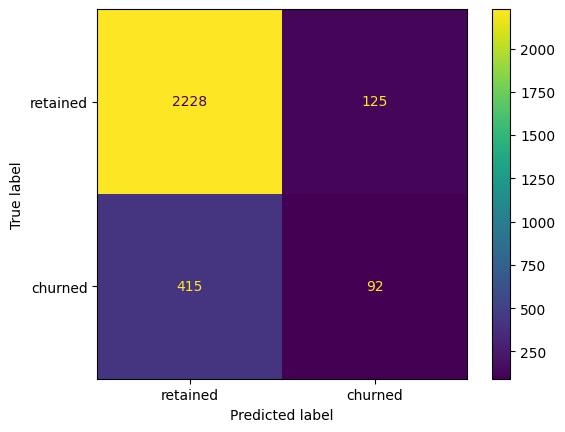

In [72]:
# Генерация массива значений для матрицы ошибок
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Составление матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

Модель предсказала в три раза больше ложноотрицательных случаев, чем ложноположительных, и правильно идентифицировала всего лишь 16.6% пользователей, которые действительно ушли.

### Важность признаков

Используем функцию `plot_importance` для проверки наиболее важных признаков итоговой модели.

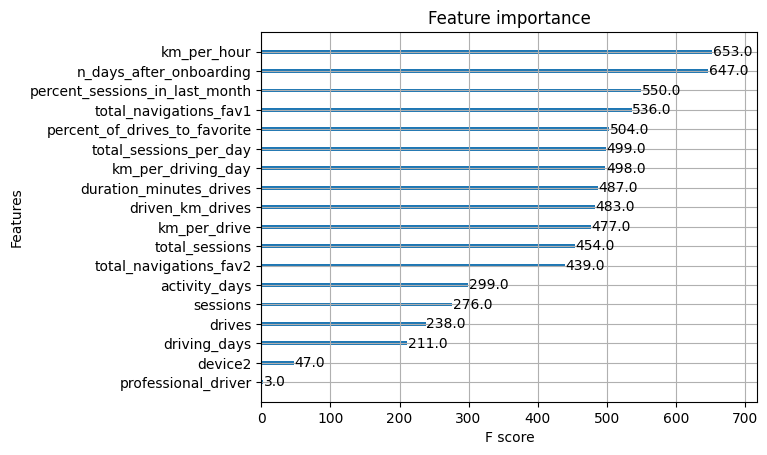

In [75]:
plot_importance(xgb_cv.best_estimator_);

Созданные признаки вошли в шесть из десяти лучших (и в три из пяти лучших). Анализ признаков часто является одним из лучших и простых способов улучшить производительность модели.

Также важные признаки в одной модели могут не совпадать с важными признаками в другой модели. Поэтому не следует считать признаки неважными без тщательного изучения и понимания их взаимосвязи с зависимой переменной, если это возможно. Различия между выбранными моделями признаков обычно вызваны сложными взаимодействиями признаков.

## Этап 4. Заключение

### Краткое изложение результатов модели

- Чтобы получить модель с наибольшей предсказательной способностью, мы разработали две различные модели для перекрестного сравнения результатов: случайный лес и XGBoost.

- Для подготовки к этой работе данные были разделены на обучающий, проверочный и тестовый наборы. Разбиение данных на три части означает, что для обучения модели доступно меньше данных, чем при разбиении на две части. Однако проведение отбора моделей на отдельном валидационном наборе позволяет тестировать модель-чемпион самостоятельно на тестовом наборе, что дает более точную оценку будущей производительности, чем разбиение данных на две части и выбор модели-чемпиона по производительности на тестовых данных.

Разработанные модели машинного обучения подчеркивают необходимость дополнительных данных для более точного прогнозирования оттока пользователей. Этот процесс моделирования подтверждает, что текущих данных недостаточно для последовательного прогнозирования оттока. Было бы полезно иметь информацию на уровне поездок для каждого пользователя (такую как время в пути, географические местоположения и т.д.). Вероятно, также было бы полезно иметь более детализированные данные, чтобы узнать, как пользователи взаимодействуют с приложением. Например, как часто они сообщают о проблемах на дороге или подтверждают предупреждения о проблемах на дороге? Наконец, могло бы быть полезно знать ежемесячное количество уникальных мест начала и завершения каждого маршрута, введенного водителем.

### Инсайты

- Созданные признаки составили шесть из десяти лучших: `km_per_hour`, `percent_sessions_in_last_month`, `total_sessions_per_day`, `percent_of_drives_to_favorite`, `km_per_drive`, `km_per_driving_day`.
- Модель XGBoost лучше подходит для данных, чем модель случайного леса.
- Комбинации моделей на основе деревьев в этом этапе проекта ценны, поскольку они достигают более высоких оценок по всем метрикам оценки и требуют меньше предварительной обработки данных по сравнению с отдельной моделью логистической регрессии. Тем не менее, сложнее понять, как они делают свои прогнозы.